# Advanced Lane Finding

Import all required libraries and display calibration image

Distorted image


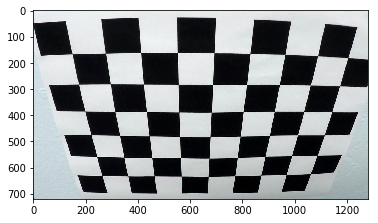

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_img = cv2.imread('camera_cal/calibration2.jpg')
print("Distorted image")
plt.imshow(test_img)

Load all calibration images and get the calibration points of of them using ```cv2.findChessboardCorners```

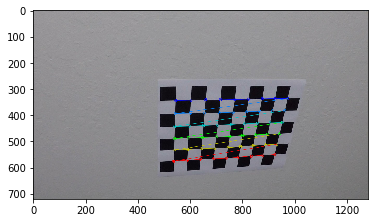

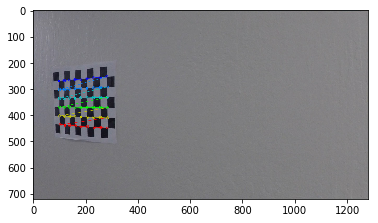

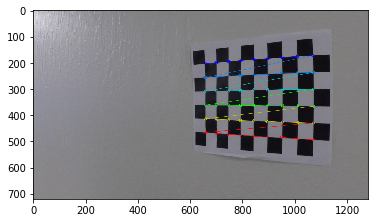

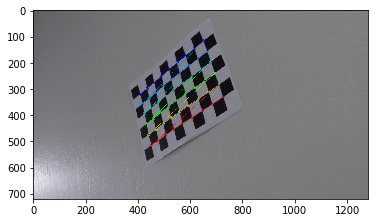

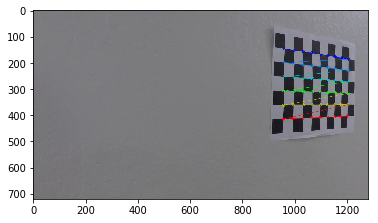

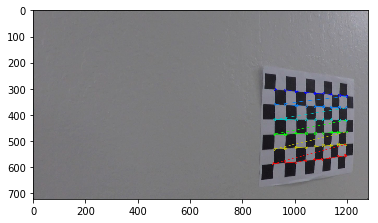

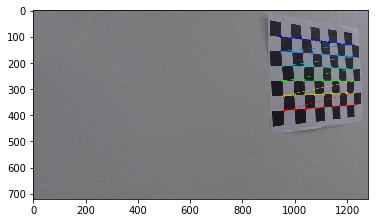

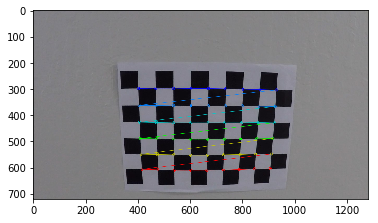

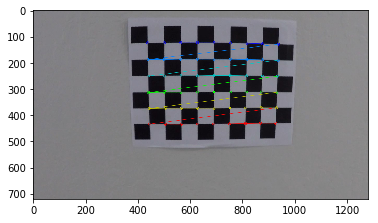

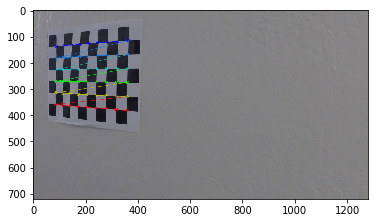

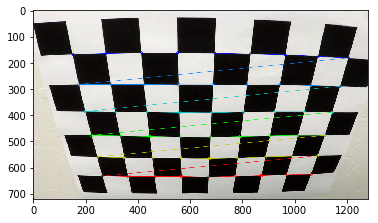

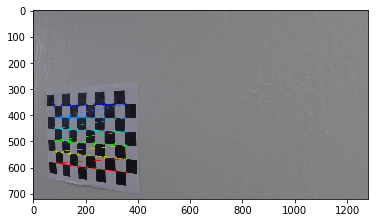

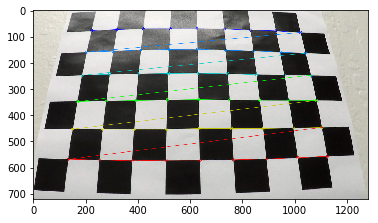

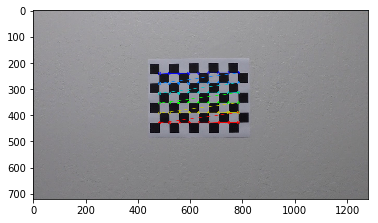

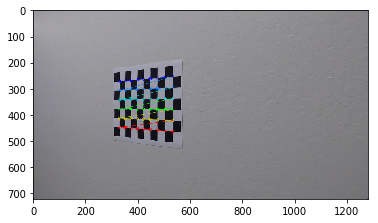

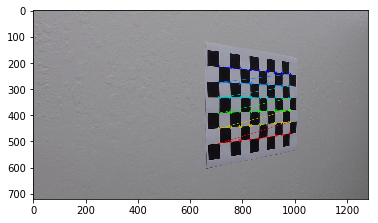

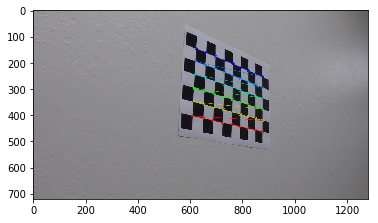

In [2]:
images = glob.glob('camera_cal/calibration*.jpg')

objpoints = []
imgpoints = []

objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

for image in images:
    img = mpimg.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.figure()
        plt.imshow(img)

Use ```cv2.calibrateCamera``` to get the parameters for image undistortion

Undistorted image


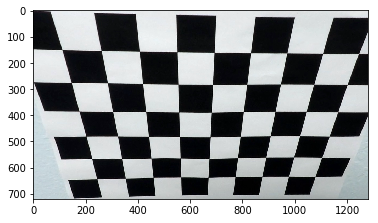

In [3]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
dst = cv2.undistort(test_img, mtx, dist, None, mtx)
print("Undistorted image")
plt.imshow(dst)

Define methods for loading the image and undistoring. Then we run it on all test images to see the results.

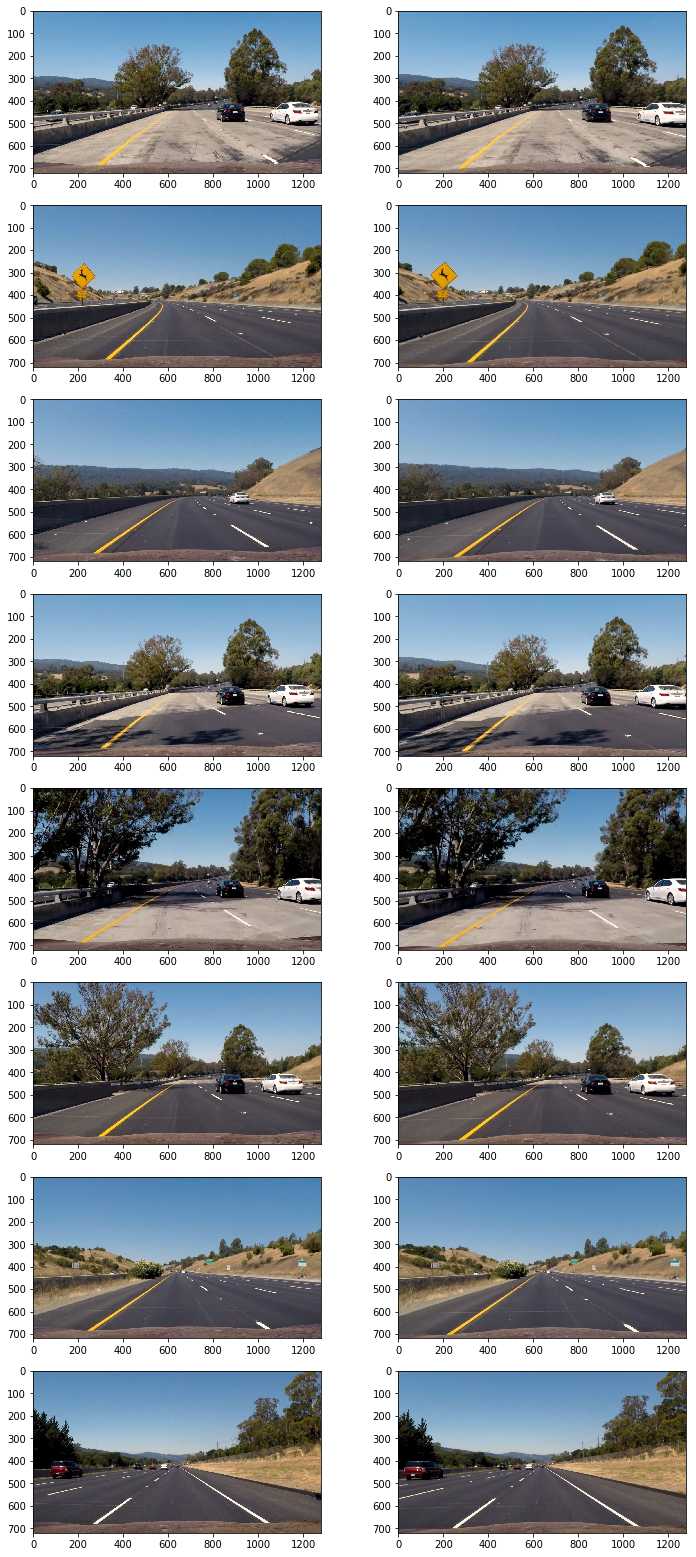

In [4]:
test_images = glob.glob('test_images/test*.jpg')
test_images.extend(glob.glob('test_images/straight_lines*.jpg'))

def load_image(img_name):
    return cv2.imread(img_name)

def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

undistorted = []
plt.figure(figsize=(12, 28))
i = 1
for timg in test_images:
    img = load_image(timg)
    dst = undistort(img)
    undistorted.append(dst)
    plt.subplot(8, 2, i)
    i += 1
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.subplot(8, 2, i)
    i += 1
    plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))

## Processing pipeline
Now that we have calibrated camera and a way to undistort the images we can define a processing pipeline.
It contains the following steps:
* Transform the image to birdeye view
* Load the L, B and C channel from the images
* Apply CLAHE, contrast limited adaptive histogram equalization to get more details out of selected channels
* Apply Sobel operator
* Turn the results into binary images
* Combine the binary images and normalize to get the most line coverage possible
* Try to fit lines based on the result:
  * Use histogram on the bottom half of the image to find the good starting point
  * Move up to find the next part of the line (image is divided into 7 parts) using small windows and checking the found pixel ratios
  * Fit a curve based on the found regions
* calculate the line curvature based on the assumed line measurements
* apply drawn lines and measurements onto the processed frame

In [5]:
def l_channel(img):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    L = hls[:,:,1]
    return L

In [6]:
def b_channel(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    B = lab[:,:,2]
    return B

In [7]:
def v_channel(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    V = hsv[:,:,2]
    return V

In [8]:
def clahe(img, clip_limit=2.0):
    clahe = cv2.createCLAHE(clip_limit, tileGridSize=(8, 8))
    return clahe.apply(img)

In [9]:
def binary_image(img, min_treshold, max_treshold):
    binary = np.zeros_like(img)
    binary[(img > min_treshold) & (img <= max_treshold)] = 1
    return binary

In [10]:
def sobel(gray, orient='x', thresh_min=0, thresh_max=255, ksize=3):
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

In [11]:
def perspective_transform(img):
    img_size = (img.shape[1], img.shape[0])
    
    src = np.float32(
        [[308, 687],
         [1129, 687],
         [555, 455],
         [735, 455]]
    )
    
    dst = np.float32(
        [[300, 720],
         [1130, 720],
         [300, 1],
         [1130, 1]]
    )
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, Minv

In [12]:
def fit_lanes(binary_warped, nwindows=9, debug=0):
    half = binary_warped[binary_warped.shape[0]//2:,:]
    histogram = np.sum(half, axis=0)
    if debug > 1:
        plt.figure()
        plt.plot(histogram)
        cv2.imwrite('processed/histogram.jpg', histogram)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    window_height = np.int(binary_warped.shape[0]/nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    margin = 80
    minpix = 50
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    y_eval = np.max(ploty)
        
    ym_per_pix = 30/720 
    xm_per_pix = 3.7/700

    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    if debug > 1:
        print(left_curverad, 'm', right_curverad, 'm')
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    if debug > 1:
        plt.figure()
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        cv2.imwrite('processed/identified_lines.jpg', out_img)
    
    return ploty, left_fitx, right_fitx, left_curverad, right_curverad

In [13]:
def draw_lines(warped, Minv, ploty, left_fitx, right_fitx, undist, left_curverad, right_curverad):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    text = "% 6.2f m, % 6.2f m" % (left_curverad, right_curverad)
    cv2.putText(result, text, (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1 ,(255, 255, 255), 2)
    return result

In [14]:
def pipeline(img, debug=0):
    if debug > 0:
        name = img
        img = load_image(img)
        plt.figure()
        plt.title('Original image ' + name)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        cv2.imwrite('processed/original.jpg', img)
    
    undist = undistort(img)
    if debug > 1:
        plt.figure()
        plt.title('Undistorted image')
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        cv2.imwrite('processed/undistorted.jpg', undist)
     
    transformed, Minv = perspective_transform(undist)
    if debug > 1:
        plt.figure()
        plt.title('Birdeye view')
        plt.imshow(cv2.cvtColor(transformed, cv2.COLOR_BGR2RGB))
        cv2.imwrite('processed/transformed.jpg', transformed)
    
    l = l_channel(transformed)
    if debug > 1:
        plt.figure()
        plt.title('L Channel')
        plt.imshow(l, cmap='gray')
        cv2.imwrite('processed/l.jpg', l)
    
    l_clahe = clahe(l)
    if debug > 1:
        plt.figure()
        plt.title('L CLAHE Channel')
        plt.imshow(l_clahe, cmap='gray')
        cv2.imwrite('processed/l_clahe.jpg', l_clahe)
    
    l_binary = binary_image(l_clahe, 210, 255)
    if debug > 1:
        plt.figure()
        plt.title('L Binary Channel')
        plt.imshow(l_binary, cmap='gray')
        cv2.imwrite('processed/l_binary.jpg', l_binary*255)
    
    b = b_channel(transformed)
    if debug > 1:
        plt.figure()
        plt.title('B Channel')
        plt.imshow(b, cmap='gray')
        cv2.imwrite('processed/b.jpg', b)
        
    b_clahe = clahe(b)
    if debug > 1:
        plt.figure()
        plt.title('B CLAHE Channel')
        plt.imshow(b_clahe, cmap='gray')
        cv2.imwrite('processed/b_clahe.jpg', b_clahe)
        
    b_binary = binary_image(b_clahe, 150, 255)
    if debug > 1:
        plt.figure()
        plt.title('B Binary Channel')
        plt.imshow(b_binary, cmap='gray')
        cv2.imwrite('processed/b_binary.jpg', b_binary*255)
        
    v = v_channel(transformed)
    if debug > 1:
        plt.figure()
        plt.title('V Channel')
        plt.imshow(v, cmap='gray')
        cv2.imwrite('processed/v.jpg', v)
    
    v_clahe = clahe(v, clip_limit=6.0)
    if debug > 1:
        plt.figure()
        plt.title('V CLAHE Channel')
        plt.imshow(v_clahe, cmap='gray')
        cv2.imwrite('processed/v_clahe.jpg', v_clahe)
        
    v_binary = binary_image(v_clahe, 220, 255)
    if debug > 1:
        plt.figure()
        plt.title('V Binary Channel')
        plt.imshow(v_binary, cmap='gray')
        cv2.imwrite('processed/v_binary.jpg', v_binary*255)
        
    sbl = sobel(l, 'x', 20, 100, ksize=11)
    if debug > 1:
        plt.figure()
        plt.title('Sobel')
        plt.imshow(sbl, cmap='gray')
        cv2.imwrite('processed/sobel.jpg', sbl*255)
        
    scores = np.zeros(img.shape[0:2]).astype('uint8')
    scores += b_binary
    scores += l_binary
    scores += v_binary
    scores += sbl
    combined = cv2.normalize(scores, None, 0, 255, cv2.NORM_MINMAX)
    if debug > 1:
        plt.figure()
        plt.title('Combined and normalized')
        plt.imshow(combined, cmap='gray')
        cv2.imwrite('processed/combined.jpg', combined)
    ploty, left_fitx, right_fitx, left_curverad, right_curverad = fit_lanes(combined, debug=debug)
    with_lines = draw_lines(combined, Minv, ploty, left_fitx, right_fitx, undist, left_curverad, right_curverad)
    if debug > 0:
        plt.figure()
        plt.title('Original image with lines')
        plt.imshow(cv2.cvtColor(with_lines, cv2.COLOR_BGR2RGB))
        cv2.imwrite('processed/original_with_lines.jpg', with_lines)
        
    return with_lines
    


Run the pipeline on a test frame

503.72094145 m 1232.07925966 m


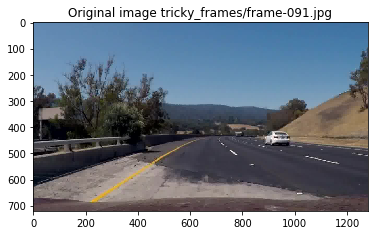

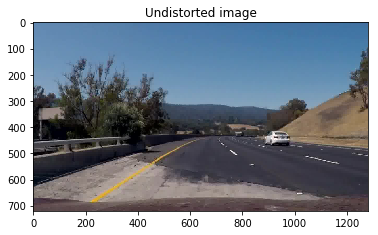

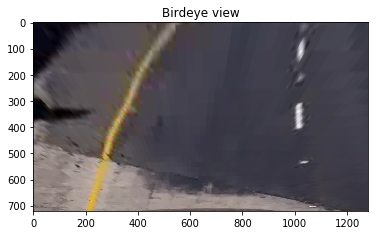

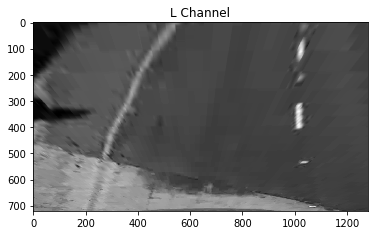

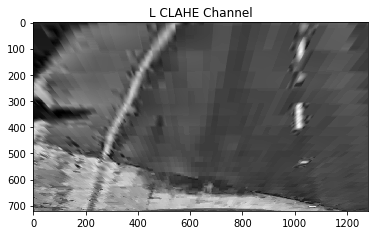

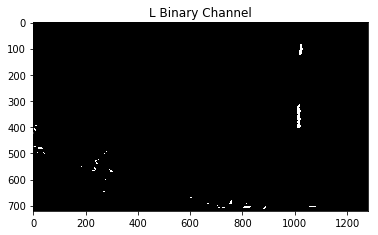

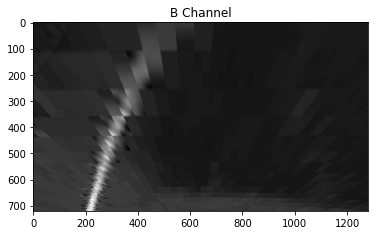

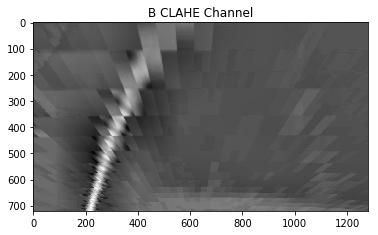

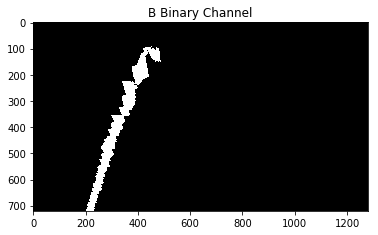

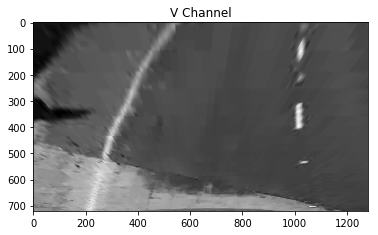

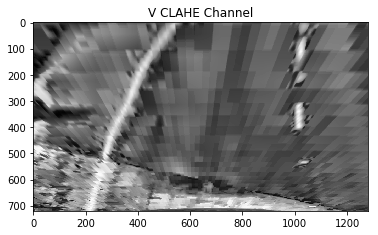

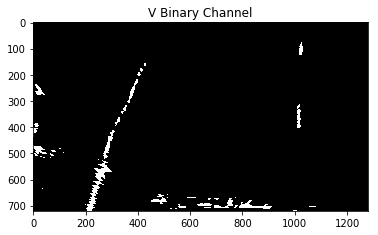

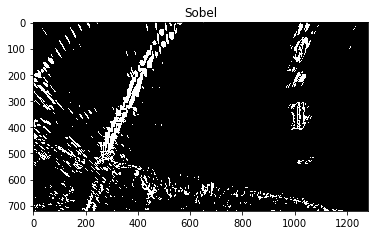

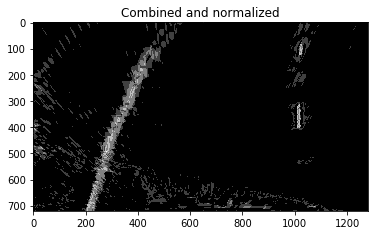

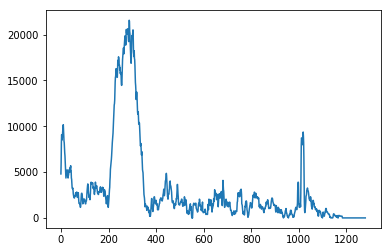

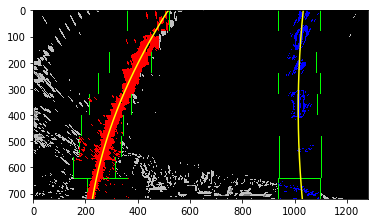

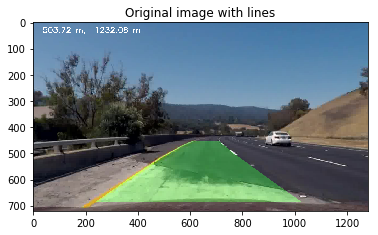

In [15]:
pipeline('tricky_frames/frame-091.jpg', debug=2);

During the implementation I found a series of tricky frame. Here I run the pipeline to see the results on them.

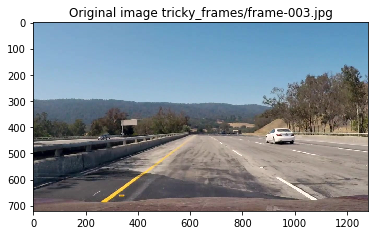

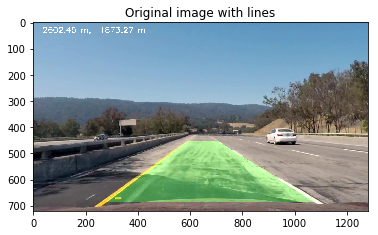

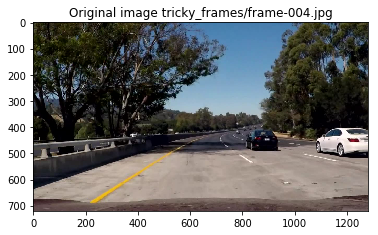

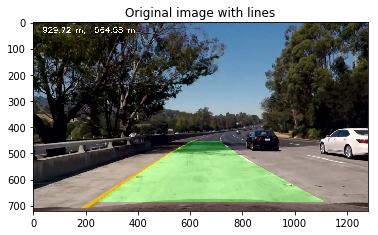

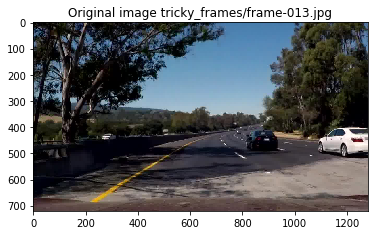

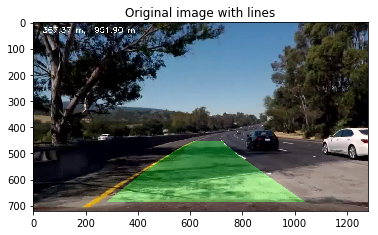

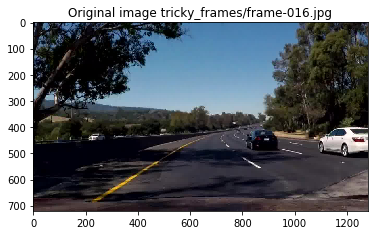

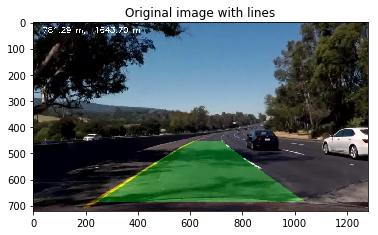

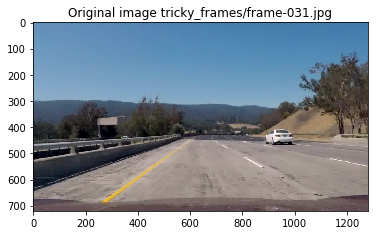

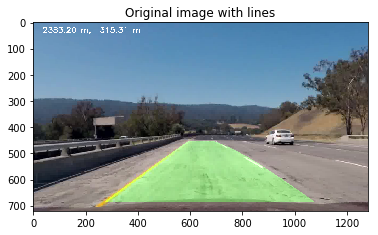

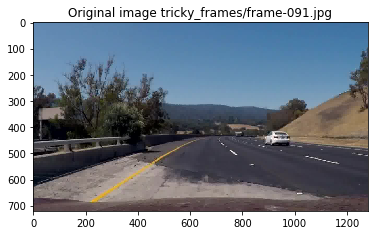

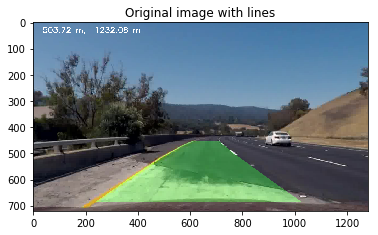

In [16]:
images = glob.glob('tricky_frames/frame-*.jpg')
for image in images:
    pipeline(image, debug=1)

## Process the video

In [17]:
def process(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return cv2.cvtColor(pipeline(img), cv2.COLOR_RGB2BGR)

In [18]:
white_output = 'output/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4") #.subclip(22, 24)
white_clip = clip1.fl_image(process)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video output/project_video.mp4
[MoviePy] Writing video output/project_video.mp4


100%|█████████▉| 1260/1261 [02:02<00:00, 10.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/project_video.mp4 

CPU times: user 3min 12s, sys: 24.5 s, total: 3min 36s
Wall time: 2min 2s


In [ ]:
white_output = 'output/challenge_video.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video output/challenge_video.mp4
[MoviePy] Writing video output/challenge_video.mp4


100%|██████████| 485/485 [00:45<00:00, 10.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/challenge_video.mp4 

CPU times: user 1min 11s, sys: 9.04 s, total: 1min 20s
Wall time: 45.9 s


In [ ]:
white_output = 'output/harder_challenge_video.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video output/harder_challenge_video.mp4
[MoviePy] Writing video output/harder_challenge_video.mp4


 84%|████████▍ | 1005/1200 [02:03<00:19, 10.02it/s]